This file (along with statistics_1) is used to evaluate the model's performance. This file is concerned with statistics for individual models rather than pipeline as a whole.

In [2]:
from datasets import Dataset
from transformers import (TextClassificationPipeline, BertTokenizer, BertForSequenceClassification,
                          RobertaTokenizerFast, RobertaForSequenceClassification)
import pickle
import pandas as pd
from collections import defaultdict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from statistics import mean

# 3 CLASSES

In [4]:
path_to_model = ...

In [5]:
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

c:\users\katya\appdata\local\programs\python\python38\lib\site-packages\huggingface_hub\file_download.py:129: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Katya\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [11]:
train = pickle.load(open('split_train_eo.pickle', 'rb'))
data = pd.DataFrame(train, columns=['text', 'tag'])
tags = set(data['tag'].tolist())
id2label = {0: 'lexical', 1: 'discourse', 2: 'gram'}
label2id = {n : tag for tag, n in id2label.items()}

In [12]:
train[:5]

[('of → from', 2),
 ('the futures (2050) → 2050', 1),
 ('analyze → analysis', 2),
 ('this → these', 1),
 ('This → These', 2)]

In [13]:
id2label

{0: 'lexical', 1: 'discourse', 2: 'gram'}

In [10]:
prediction = TextClassificationPipeline(
    model=RobertaForSequenceClassification.from_pretrained(path_to_model, num_labels=len(id2label), id2label=id2label, label2id=label2id),
    tokenizer=tokenizer,
)

In [12]:
prediction("war → conflict")

[{'label': 'lexical', 'score': 0.8990375399589539}]

In [14]:
data = pd.DataFrame(train, columns=['text', 'label'])
data['tag'] = data.apply(lambda x: id2label[x['label']], axis=1)
data

,text,label,tag
0,of → from,2,gram
1,the futures (2050) → 2050,1,discourse
2,analyze → analysis,2,gram
3,this → these,1,discourse
4,This → These,2,gram
...,...,...,...
45527,USA → American,2,gram
45528,for → in,2,gram
45529,", who → who",2,gram
45530,of → aged,0,lexical


In [15]:
dataset = Dataset.from_pandas(data[['text', 'label', 'tag']])
dataset = dataset.train_test_split(test_size=0.2, seed=42)
len(dataset['train']), len(dataset['test'])
df = dataset['test'].to_pandas()
# df

(36425, 9107)

In [30]:
errors = dict()

for i in id2label.keys():
    sents = df.loc[df['label'] == i]['text'].tolist()
    errors[id2label[i]] = sents
    

In the following function, the 'certain' threshold for final predictions is set at 0.85 -- this is an artifact of the earlier evaluations and is not used further.

In [49]:
examples = []
corr, wrong, uncertain = 0, 0, 0

for error, sents in tqdm(errors.items()):
    class_wrong, class_corr, class_uncertain = 0, 0, 0
    for sent in tqdm(sents):
        pr = prediction(sent)[0]
        examples.append((sent, error, pr['label'], pr['score']))
        if pr['score'] > 0.85:
            if pr['label'] == error:
                class_corr += 1
            else:
                class_wrong += 1
        else:
            class_uncertain += 1
            
            
    corr += class_corr
    uncertain += class_uncertain
    wrong += class_wrong
        
    print(f'identified correctly in {error}: {class_corr}/{class_corr+class_wrong}, {class_corr/(max(class_corr+class_wrong, 1))*100}%, uncertain {class_uncertain}, total {class_corr+class_wrong+class_uncertain}')
    
print(f'in total: {corr} / {corr/(corr+wrong+uncertain)} correct, {wrong} / {wrong/(corr+wrong+uncertain)} wrong, {uncertain} / {uncertain/(corr+wrong+uncertain)} uncertain')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2890 [00:00<?, ?it/s]

identified correctly in lexical: 1701/1967, 86.47686832740213%, uncertain 923, total 2890


  0%|          | 0/2038 [00:00<?, ?it/s]

identified correctly in discourse: 1102/1237, 89.08649959579628%, uncertain 801, total 2038


  0%|          | 0/4179 [00:00<?, ?it/s]

identified correctly in gram: 3246/3390, 95.75221238938053%, uncertain 789, total 4179
in total: 6049 / 0.6642143406171077 correct, 545 / 0.05984407598550565 wrong, 2513 / 0.2759415833973866 uncertain


In [33]:
df = pd.DataFrame(examples, columns=['error', 'target', 'pred', 'score'])

In [48]:
df.groupby(['target', 'pred']).agg({'error':'count', 'score':['mean', 'median', 'var']})

error     score                    
                    count      mean    median       var
target    pred                                         
discourse discourse  1601  0.860492  0.912022  0.017480
          gram        225  0.754710  0.791175  0.029604
          lexical     212  0.699108  0.670941  0.031080
gram      discourse   213  0.724480  0.740948  0.025567
          gram       3701  0.939350  0.982584  0.010324
          lexical     265  0.746146  0.764241  0.026087
lexical   discourse   251  0.733339  0.760736  0.024798
          gram        420  0.790516  0.827214  0.025744
          lexical    2219  0.894712  0.956900  0.016931

In [35]:
df.to_excel('errors_3_classes_pred.xlsx')

In [3]:
df = pd.read_excel('errors_3_classes_pred.xlsx')

(total predictions, correct predictions):

In [4]:
len(df), len(df[df['target'] == df['pred']])

(9107, 7521)

Calculate precision, recall, F1 and F0.5-measures and mean certainty for each class.

In [26]:
def prec_rec_f1(cl):
    
#     df_ = df[df['score'] > certain_treshold]
    
    TP = len(df[(df['target'] == cl) & (df['pred'] == cl)])
    FP = len(df[(df['target'] != cl) & (df['pred'] == cl)])
    TN = len(df[(df['target'] != cl) & (df['pred'] != cl)])
    FN = len(df[(df['target'] == cl) & (df['pred'] != cl)])
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = TP / (TP + .5*(FP+FN))
    f05 = 1.25 * TP / (1.25 * TP + 0.25 * FN + FP)
    mean_score = mean(df[df['target'] == cl]['score'])
    
    try:
        return precision, recall, f1, f05, mean_score
    except Exception:
        return None, None, None, None, None

In [27]:
classes = set(df['target'].tolist())

pr, rec, f1, f05, means = [], [], [], [], []
for cl in classes:
        m1, m2, m3, m4, mean_score = prec_rec_f1(cl)
        pr.append(m1)
        rec.append(m2)
        f1.append(m3)
        f05.append(m4)
        means.append(mean_score)
    
metrics = pd.DataFrame(data = list(zip(classes, pr, rec, f1, f05, means)), columns=['class', 'precision', 'recall', 'F1', 'F0.5', 'mean score'])
metrics

,class,precision,recall,F1,F0.5,mean score
0,lexical,0.823071,0.767820,0.794486,0.811394,0.865554
1,discourse,0.775303,0.785574,0.780405,0.777335,0.832026
2,gram,0.851588,0.885619,0.868270,0.858183,0.916147


In [20]:
from collections import Counter

In [21]:
Counter(df['target'])

Counter({'lexical': 2890, 'discourse': 2038, 'gram': 4179})

Statistics on incorrect predictions only:

In [5]:
incorrect = df[df['target'] != df['pred']]
incorrect.head()

,Unnamed: 0,error,target,pred,score
2,2,from 2014 to 2015 → during the given period,lexical,discourse,0.584466
5,5,the least → The smallest one,lexical,discourse,0.586270
6,6,in → into,lexical,gram,0.959141
9,9,forecasted → predicted,lexical,gram,0.710353
10,10,which causes → the reasons of that,lexical,discourse,0.453980


In [5]:
incorrect.groupby(['target', 'pred']).agg({'error': 'count', 'score':['mean', 'median']})

error     score          
                    count      mean    median
target    pred                               
discourse gram        225  0.754710  0.791175
          lexical     212  0.699108  0.670941
gram      discourse   213  0.724480  0.740948
          lexical     265  0.746146  0.764241
lexical   discourse   251  0.733339  0.760736
          gram        420  0.790516  0.827214

Build boxplots for each class -- a visual representation of median and 1st and 3rd quartiles:

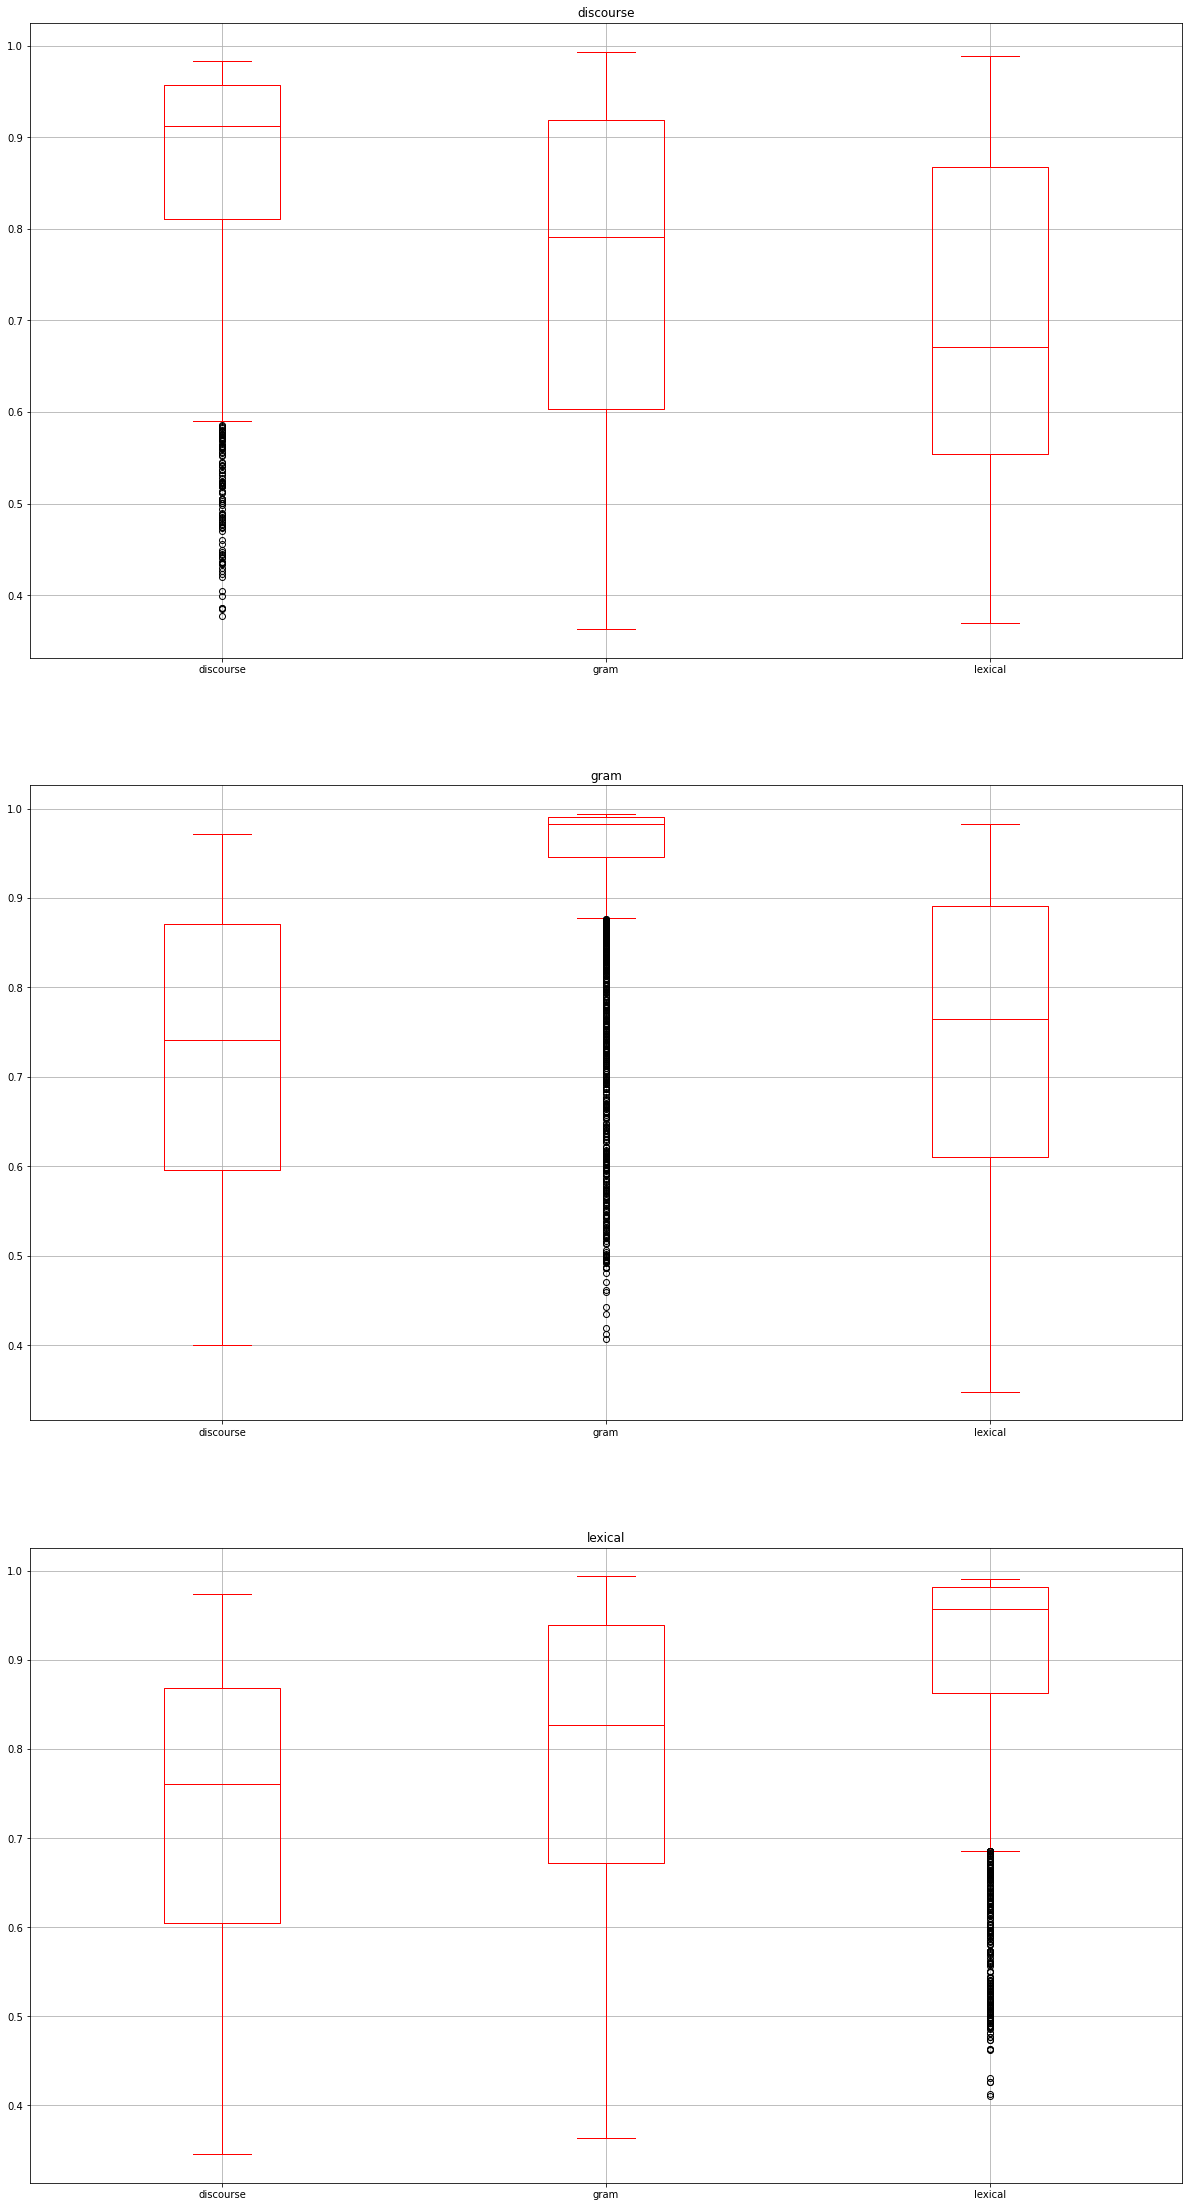

In [6]:
tags = ['discourse', 'gram', 'lexical']
fig, ax = plt.subplots(len(tags), figsize=(20,40))
for n, tag in enumerate(tags):
    sub = df.groupby(['target'])
    labels = sorted(set(sub.get_group(tag)['pred'].tolist()))
#     print(labels)
    bp = df[df['target'] == tag].boxplot(column='score', by=['target', 'pred'], 
                                         ax=ax[n], color='r')
    ax[n].set_title(tag)
    ax[n].set_xticks(range(1, len(labels)+1), labels=labels)
    ax[n].set_xlabel('')
    
fig.suptitle('')
plt.show()

As seen on a single boxplot:

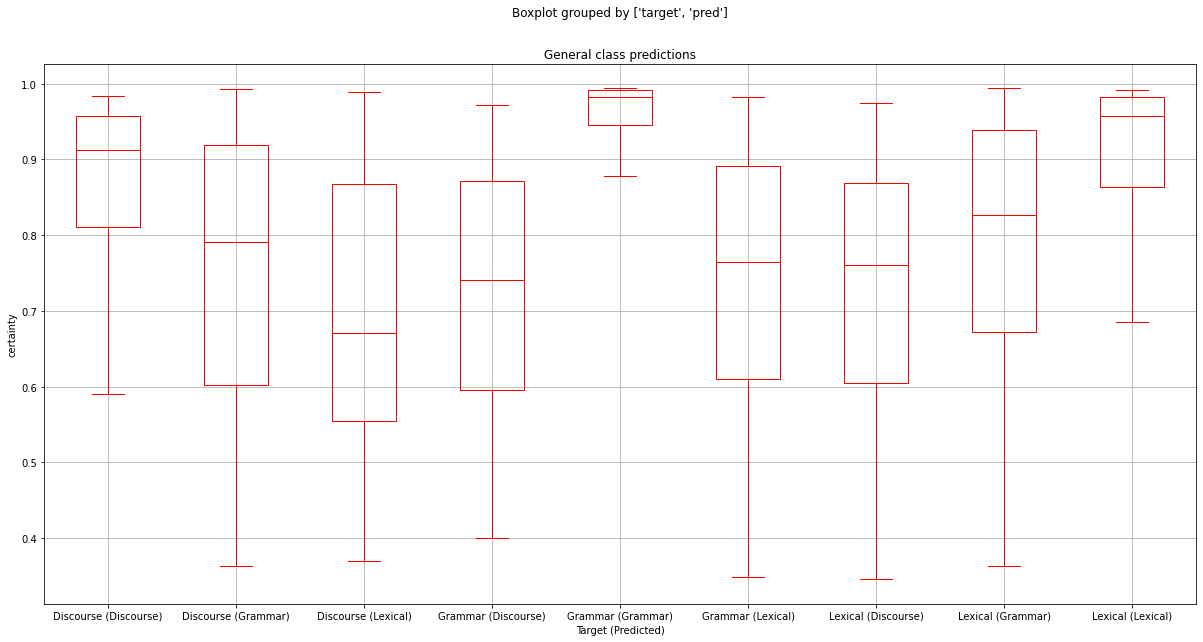

In [21]:
fig, ax = plt.subplots(figsize=(20,10))
bp = df.boxplot(column='score', by=['target', 'pred'], ax=ax, color='r', showfliers=False)
bp.get_figure().gca().set_title("")
ax.set_title('General class predictions')
labels = ['Discourse (Discourse)', 'Discourse (Grammar)', 'Discourse (Lexical)',
              'Grammar (Discourse)', 'Grammar (Grammar)', 'Grammar (Lexical)',
              'Lexical (Discourse)', 'Lexical (Grammar)', 'Lexical (Lexical)']
ax.set_xticks(range(1, len(labels)+1), labels=labels)
ax.set_xlabel('Target (Predicted)')
ax.set_ylabel('certainty')
plt.title('General class predictions')
plt.savefig('general_pred.png')
plt.show()

# DISCOURSE

In [2]:
path_to_model = ...
tokenizer = RobertaTokenizerFast.from_pretrained(path_to_model)
train = pickle.load(open('split_train_disc_eo.pickle', 'rb'))
data = pd.DataFrame(train, columns=['text', 'tag'])
tags = set(data['tag'].tolist())
id2label = {n:tag for n, tag in enumerate(['Absence_comp_sent', 'Absence_explanation', 
                                           'Inappropriate_register', 
                                            'Linking_device', 'Redundant_comp', 
                                            'Ref_device'])}
label2id = {n:tag for tag, n in id2label.items()}

In [3]:
id2label

{0: 'Absence_comp_sent',
 1: 'Absence_explanation',
 2: 'Inappropriate_register',
 3: 'Linking_device',
 4: 'Redundant_comp',
 5: 'Ref_device'}

In [49]:
prediction = TextClassificationPipeline(
    model=RobertaForSequenceClassification.from_pretrained(path_to_model, num_labels=len(id2label), id2label=id2label, label2id=label2id),
    tokenizer=tokenizer,
)

In [4]:
data = pd.DataFrame(train, columns=['text', 'label'])
data['tag'] = data.apply(lambda x: id2label[x['label']], axis=1)
dataset = Dataset.from_pandas(data[['text', 'label', 'tag']]).class_encode_column('label')
dataset = dataset.train_test_split(test_size=0.2, seed=42)
len(dataset['train']), len(dataset['test'])
df = dataset['test'].to_pandas()

Stringifying the column:   0%|          | 0/10388 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/10388 [00:00<?, ? examples/s]

(8310, 2078)

In [53]:
examples = []
corr, wrong, uncertain = 0, 0, 0

for error, sents in tqdm(errors.items()):
    class_wrong, class_corr, class_uncertain = 0, 0, 0
    for sent in tqdm(sents):
        pr = prediction(sent)[0]
        examples.append((sent, error, pr['label'], pr['score']))
        if pr['score'] > 0.85:
            if pr['label'] == error:
                class_corr += 1
            else:
                class_wrong += 1
        else:
            class_uncertain += 1
            
            
    corr += class_corr
    uncertain += class_uncertain
    wrong += class_wrong
        
    print(f'identified correctly in {error}: {class_corr}/{class_corr+class_wrong}, {class_corr/(max(class_corr+class_wrong, 1))*100}%, uncertain {class_uncertain}, total {class_corr+class_wrong+class_uncertain}')
    
print(f'in total: {corr} / {corr/(corr+wrong+uncertain)} correct, {wrong} / {wrong/(corr+wrong+uncertain)} wrong, {uncertain} / {uncertain/(corr+wrong+uncertain)} uncertain')

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/741 [00:00<?, ?it/s]

identified correctly in Absence_comp_sent: 386/422, 91.4691943127962%, uncertain 319, total 741


  0%|          | 0/458 [00:00<?, ?it/s]

identified correctly in Absence_explanation: 139/174, 79.88505747126436%, uncertain 284, total 458


  0%|          | 0/327 [00:00<?, ?it/s]

identified correctly in Inappropriate_register: 183/205, 89.26829268292683%, uncertain 122, total 327


  0%|          | 0/162 [00:00<?, ?it/s]

identified correctly in Linking_device: 106/117, 90.5982905982906%, uncertain 45, total 162


  0%|          | 0/111 [00:00<?, ?it/s]

identified correctly in Redundant_comp: 42/56, 75.0%, uncertain 55, total 111


  0%|          | 0/279 [00:00<?, ?it/s]

identified correctly in Ref_device: 136/164, 82.92682926829268%, uncertain 115, total 279
in total: 992 / 0.4773820981713186 correct, 146 / 0.07025986525505294 wrong, 940 / 0.4523580365736285 uncertain


In [63]:
df = pd.DataFrame(examples, columns=['error', 'target', 'pred', 'score'])
df.head()

,error,target,pred,score
0,active → to be active,Absence_comp_sent,Absence_comp_sent,0.918563
1,sector → is,Absence_comp_sent,Absence_comp_sent,0.540116
2,"The second question, that I can notice in a st...",Absence_comp_sent,Absence_comp_sent,0.658758
3,their minds → the qualities of their minds,Absence_comp_sent,Absence_explanation,0.812093
4,public health → the level of public health,Absence_comp_sent,Absence_comp_sent,0.913004


In [56]:
df.to_excel('errors_disc_pred.xlsx')

In [7]:
df = pd.read_excel('errors_disc_pred.xlsx', index_col=0)

In [8]:
df.head()

,error,target,pred,score
0,active → to be active,Absence_comp_sent,Absence_comp_sent,0.918563
1,sector → is,Absence_comp_sent,Absence_comp_sent,0.540116
2,"The second question, that I can notice in a st...",Absence_comp_sent,Absence_comp_sent,0.658758
3,their minds → the qualities of their minds,Absence_comp_sent,Absence_explanation,0.812093
4,public health → the level of public health,Absence_comp_sent,Absence_comp_sent,0.913004


In [5]:
df.groupby(['target', 'pred']).agg({'error':'count', 'score':['mean', 'median', 'var']})

error     score            \
                                              count      mean    median   
target                 pred                                               
Absence_comp_sent      Absence_comp_sent        574  0.861661  0.928697   
                       Absence_explanation      121  0.698644  0.697941   
                       Inappropriate_register     5  0.831450  0.832158   
                       Linking_device            17  0.714113  0.768479   
                       Redundant_comp             5  0.598257  0.529726   
                       Ref_device                19  0.678424  0.718761   
Absence_explanation    Absence_comp_sent        138  0.717844  0.717958   
                       Absence_explanation      303  0.795023  0.833168   
                       Inappropriate_register     7  0.845859  0.821223   
                       Linking_device             2  0.619409  0.619409   
                       Redundant_comp             2  0.388840  0.388840   
                       Ref_device                 6  0.738420  0.810030   
Inappropriate_register Absence_comp_sent         16  0.752530  0.794615   
                       Absence_explanation       17  0.662896  0.642087   
                       Inappropriate_register   261  0.898834  0.965107   
                       Linking_device            12  0.803717  0.893086   
                       Redundant_comp            14  0.669322  0.722338   
                       Ref_device                 7  0.674665  0.649228   
Linking_device         Absence_comp_sent         21  0.739925  0.800586   
                       Absence_explanation        5  0.423147  0.369488   
                       Inappropriate_register     1  0.655111  0.655111   
                       Linking_device           126  0.887860  0.939405   
                       Redundant_comp             3  0.576013  0.510127   
                       Ref_device                 6  0.697222  0.669136   
Redundant_comp         Absence_comp_sent         13  0.758409  0.735978   
                       Absence_explanation       11  0.612024  0.572827   
                       Inappropriate_register     6  0.703216  0.733063   
                       Linking_device            11  0.784275  0.807273   
                       Redundant_comp            64  0.831730  0.873106   
                       Ref_device                 6  0.752290  0.766007   
Ref_device             Absence_comp_sent         36  0.697105  0.714827   
                       Absence_explanation       31  0.708049  0.765701   
                       Inappropriate_register    19  0.746084  0.810427   
                       Linking_device             9  0.768634  0.894713   
                       Redundant_comp             4  0.720760  0.737232   
                       Ref_device               180  0.897634  0.967676   

                                                         
                                                    var  
target                 pred                              
Absence_comp_sent      Absence_comp_sent       0.020321  
                       Absence_explanation     0.021573  
                       Inappropriate_register  0.006976  
                       Linking_device          0.044295  
                       Redundant_comp          0.019625  
                       Ref_device              0.026592  
Absence_explanation    Absence_comp_sent       0.024319  
                       Absence_explanation     0.020996  
                       Inappropriate_register  0.002365  
                       Linking_device          0.003719  
                       Redundant_comp          0.015449  
                       Ref_device              0.036698  
Inappropriate_register Absence_comp_sent       0.035879  
                       Absence_explanation     0.029293  
                       Inappropriate_register  0.014474  
                       Linking_device          0.034275  
                  

In [32]:
def prec_rec_f1(cl):
    
#     df_ = df[df['score'] > certain_treshold]
    
    TP = len(df[(df['target'] == cl) & (df['pred'] == cl)])
    FP = len(df[(df['target'] != cl) & (df['pred'] == cl)])
    TN = len(df[(df['target'] != cl) & (df['pred'] != cl)])
    FN = len(df[(df['target'] == cl) & (df['pred'] != cl)])
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = TP / (TP + .5*(FP+FN))
    f05 = 1.25 * TP / (1.25 * TP + 0.25 * FN + FP)
    mean_score = mean(df[df['target'] == cl]['score'])
    
    try:
        return precision, recall, f1, f05, mean_score
    except Exception:
        return None, None, None, None, None

In [33]:
classes = set(df['target'].tolist())

pr, rec, f1, f05, means = [], [], [], [], []
for cl in classes:
        m1, m2, m3, m4, mean_score = prec_rec_f1(cl)
        pr.append(m1)
        rec.append(m2)
        f1.append(m3)
        f05.append(m4)
        means.append(mean_score)
    
metrics = pd.DataFrame(data = list(zip(classes, pr, rec, f1, f05, means)), columns=['class', 'precision', 'recall', 'F1', 'F0.5', 'mean score'])
metrics

,class,precision,recall,F1,F0.5,mean score
0,Linking_device,0.711864,0.777778,0.743363,0.724138,0.840068
1,Redundant_comp,0.695652,0.576577,0.630542,0.668058,0.785427
2,Inappropriate_register,0.872910,0.798165,0.833866,0.856861,0.861294
3,Ref_device,0.803571,0.645161,0.715706,0.765957,0.833677
4,Absence_comp_sent,0.719298,0.774629,0.745939,0.729723,0.824976
5,Absence_explanation,0.620902,0.661572,0.640592,0.628631,0.769263


In [55]:
from collections import Counter
Counter(df['target'].tolist())

Counter({'Absence_comp_sent': 741,
         'Absence_explanation': 458,
         'Inappropriate_register': 327,
         'Linking_device': 162,
         'Redundant_comp': 111,
         'Ref_device': 279})

In [56]:
from sklearn.metrics import fbeta_score

for mode in ['weighted', 'micro', 'macro']:
    print(f'{mode} F0.5', 
          fbeta_score(df['target'],
                      df['pred'], 
                      beta=0.5, 
                      average=mode))

weighted F0.5 0.728584291822883
micro F0.5 0.7256977863330125
macro F0.5 0.728894808978449


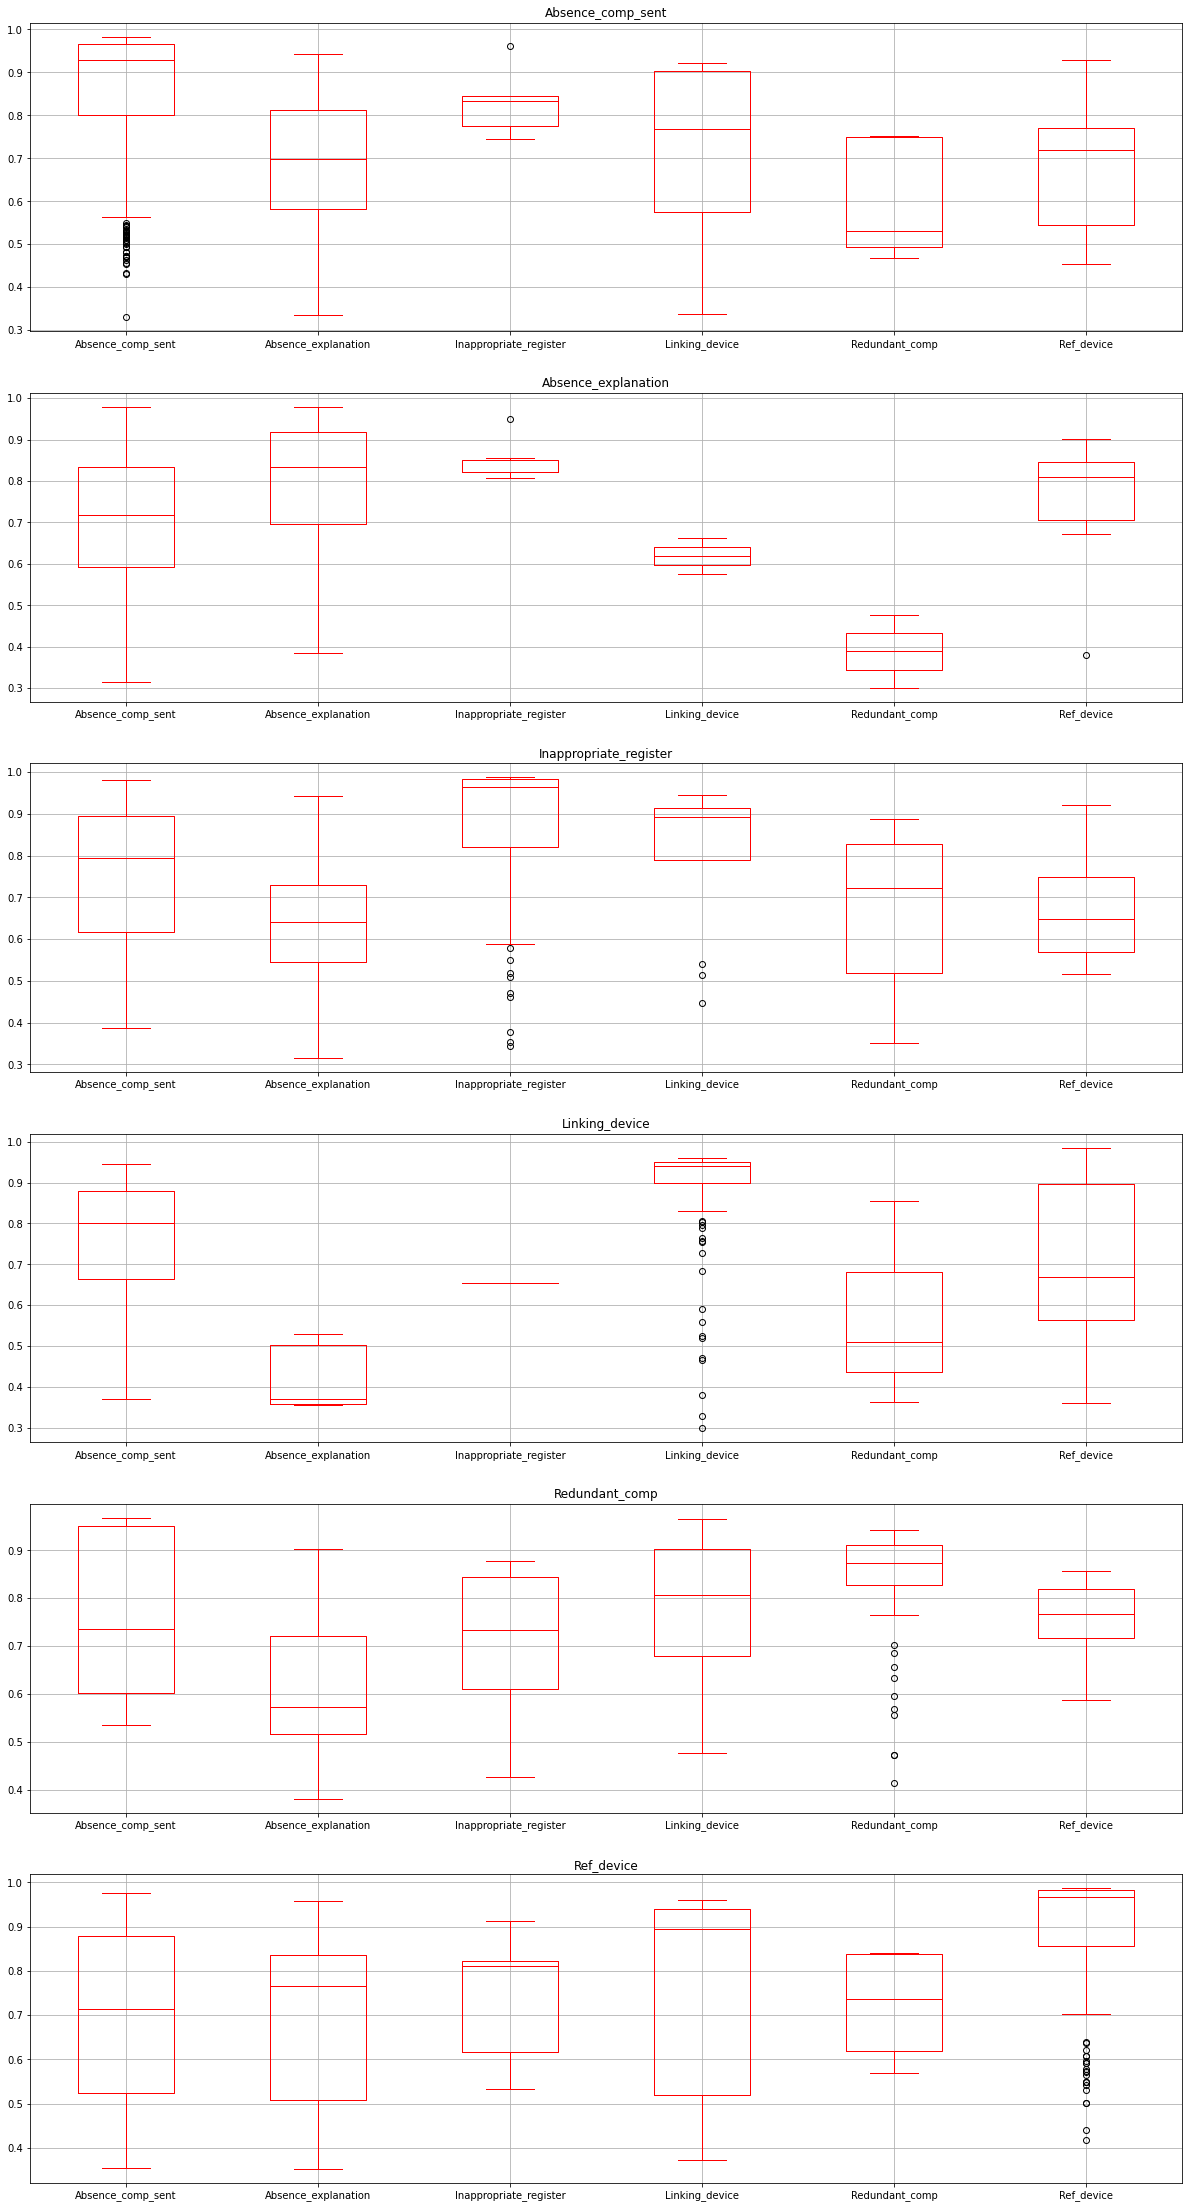

In [11]:
tags = ['Absence_comp_sent', 'Absence_explanation', 
        'Inappropriate_register', 
        'Linking_device', 'Redundant_comp', 
        'Ref_device']
fig, ax = plt.subplots(len(tags), figsize=(20,40))
for n, tag in enumerate(tags):
    sub = df.groupby(['target'])
    labels = sorted(set(sub.get_group(tag)['pred'].tolist()))
#     print(labels)
    bp = df[df['target'] == tag].boxplot(column='score', by=['target', 'pred'], 
                                         ax=ax[n], color='r')
    ax[n].set_title(tag)
    ax[n].set_xticks(range(1, len(labels)+1), labels=labels)
    ax[n].set_xlabel('')
    
fig.suptitle('')
plt.show()

# GRAMMAR

In [46]:
path_to_model = ...
tokenizer = RobertaTokenizerFast.from_pretrained(path_to_model)
train = pickle.load(open('split_train_gram_eo.pickle', 'rb'))
data = pd.DataFrame(train, columns=['text', 'tag'])
id2label = {
    0: "Verb_pattern",
    1: "Confusion_of_structures",
    2: "Voice",
    3: "Comparison_degree",
    4: "Formational_affixes",
    5: "Prepositions",
    6: "Category_confusion",
    7: "Agreement_errors",
    8: "Numerals",
    9: "Tense_form",
    10: "Relative_clause",
  }
label2id = {n:tag for tag, n in id2label.items()}

In [47]:
prediction = TextClassificationPipeline(
    model=RobertaForSequenceClassification.from_pretrained(path_to_model),
    tokenizer=tokenizer,
)

In [49]:
data = pd.DataFrame(train, columns=['text', 'label'])
data['tag'] = data.apply(lambda x: id2label[x['label']], axis=1)
dataset = Dataset.from_pandas(data[['text', 'label', 'tag']]).class_encode_column('label')
dataset = dataset.train_test_split(test_size=0.2, seed=42)
# len(dataset['train']), len(dataset['test'])
df = dataset['test'].to_pandas()

Stringifying the column:   0%|          | 0/20767 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/20767 [00:00<?, ? examples/s]

In the original Grammar model, there's an issue where the id2label does not match actual values. The following part creates a dictionary that will match the predicted labels to their actual values. If the model is trained from anew, however, there is no need for the dictionary.

In [50]:
errors = dict()

for i in id2label.keys():
    print(id2label[i], end=' ')
    sents = df.loc[df['tag'] == id2label[i]]['text'].tolist()
    print(len(sents))
    errors[id2label[i]] = sents

Verb_pattern 265
Confusion_of_structures 104
Voice 196
Comparison_degree 157
Formational_affixes 327
Prepositions 969
Category_confusion 592
Agreement_errors 854
Numerals 286
Tense_form 237
Relative_clause 167


In [51]:
real = {}
for k, l in errors.items():
    l = [pr['label'] for pr in prediction(l[:30])]
    mode = max(set(l), key=l.count)
    print(mode)
    print(k, '\n')
    real[mode] = k

Verb_pattern
Verb_pattern 

Confusion_of_structures
Confusion_of_structures 

Comparison_degree
Voice 

Formational_affixes
Comparison_degree 

Prepositions
Formational_affixes 

Category_confusion
Prepositions 

Agreement_errors
Category_confusion 

Numerals
Agreement_errors 

Tense_form
Numerals 

Numerals
Tense_form 

Voice
Relative_clause 



In [54]:
for i in errors.keys():
    if i not in real.keys():
        print(f'{i} not in keys')
    if i not in real.values():
        print(f'{i} not in values')

Agreement_errors not in values
Relative_clause not in keys


In [55]:
real['Relative_clause'] = 'Tense_form'
real['Numerals'] = 'Agreement_errors'

In [56]:
assert len(real) == len(label2id)
assert len(set(real.keys())) == len(real.keys())
assert len(set(real.values())) == len(real.values())
assert set(real.values()) == set(real.keys())

In [57]:
pr = prediction('do → does')[0]
pr['label'], real[pr['label']]

('Numerals', 'Agreement_errors')

In [295]:
real

{'Verb_pattern': 'Verb_pattern',
 'Confusion_of_structures': 'Confusion_of_structures',
 'Comparison_degree': 'Voice',
 'Formational_affixes': 'Comparison_degree',
 'Prepositions': 'Formational_affixes',
 'Category_confusion': 'Prepositions',
 'Agreement_errors': 'Category_confusion',
 'Numerals': 'Agreement_errors',
 'Tense_form': 'Numerals',
 'Voice': 'Relative_clause',
 'Relative_clause': 'Tense_form'}

Now we can proceed with the prediction.

In [58]:
examples = []
corr, wrong, uncertain = 0, 0, 0

for error, sents in tqdm(errors.items()):
    class_wrong, class_corr, class_uncertain = 0, 0, 0
    for sent in tqdm(sents):
        pr = prediction(sent)[0]
        examples.append((sent, error, real[pr['label']], pr['score']))
        if pr['score'] > 0.85:
            if real[pr['label']] == error:
                class_corr += 1
            else:
                class_wrong += 1
        else:
            class_uncertain += 1
            
            
    corr += class_corr
    uncertain += class_uncertain
    wrong += class_wrong
        
    print(f'identified correctly in {error}: {class_corr}/{class_corr+class_wrong}, {class_corr/(max(class_corr+class_wrong, 1))*100}%, uncertain {class_uncertain}, total {class_corr+class_wrong+class_uncertain}')
    
print(f'in total: {corr} / {corr/(corr+wrong+uncertain)} correct, {wrong} / {wrong/(corr+wrong+uncertain)} wrong, {uncertain} / {uncertain/(corr+wrong+uncertain)} uncertain')

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

identified correctly in Verb_pattern: 126/137, 91.97080291970804%, uncertain 128, total 265


  0%|          | 0/104 [00:00<?, ?it/s]

identified correctly in Confusion_of_structures: 0/12, 0.0%, uncertain 92, total 104


  0%|          | 0/196 [00:00<?, ?it/s]

identified correctly in Voice: 5/8, 62.5%, uncertain 188, total 196


  0%|          | 0/157 [00:00<?, ?it/s]

identified correctly in Comparison_degree: 142/142, 100.0%, uncertain 15, total 157


  0%|          | 0/327 [00:00<?, ?it/s]

identified correctly in Formational_affixes: 87/116, 75.0%, uncertain 211, total 327


  0%|          | 0/969 [00:00<?, ?it/s]

identified correctly in Prepositions: 882/896, 98.4375%, uncertain 73, total 969


  0%|          | 0/592 [00:00<?, ?it/s]

identified correctly in Category_confusion: 218/245, 88.9795918367347%, uncertain 347, total 592


  0%|          | 0/854 [00:00<?, ?it/s]

identified correctly in Agreement_errors: 696/700, 99.42857142857143%, uncertain 154, total 854


  0%|          | 0/286 [00:00<?, ?it/s]

identified correctly in Numerals: 187/191, 97.90575916230367%, uncertain 95, total 286


  0%|          | 0/237 [00:00<?, ?it/s]

identified correctly in Tense_form: 0/70, 0.0%, uncertain 167, total 237


  0%|          | 0/167 [00:00<?, ?it/s]

identified correctly in Relative_clause: 153/153, 100.0%, uncertain 14, total 167
in total: 2496 / 0.6008666345690901 correct, 174 / 0.04188733750601829 wrong, 1484 / 0.3572460279248917 uncertain


In [59]:
df = pd.DataFrame(examples, columns=['error', 'target', 'pred', 'score'])
df.head()

,error,target,pred,score
0,considered → are considered to be,Verb_pattern,Voice,0.846305
1,"offer to many people works, and → offer jobs t...",Verb_pattern,Verb_pattern,0.503557
2,listen → listen to,Verb_pattern,Verb_pattern,0.911679
3,taught to → taught,Verb_pattern,Verb_pattern,0.855675
4,spend all their time by → spend all their time,Verb_pattern,Verb_pattern,0.835138


In [62]:
df.to_excel('errors_gram_pred.xlsx')

In [8]:
df = pd.read_excel('errors_gram_pred.xlsx')

In [46]:
classes = set(df['target'].tolist())

pr, rec, f1, f05, means = [], [], [], [], []
for cl in classes:
        m1, m2, m3, m4, mean_score = prec_rec_f1(cl)
        pr.append(m1)
        rec.append(m2)
        f1.append(m3)
        f05.append(m4)
        means.append(mean_score)
    
metrics = pd.DataFrame(data = list(zip(classes, pr, rec, f1, f05, means)), columns=['class', 'precision', 'recall', 'F1', 'F0.5', 'mean score'])
metrics

,class,precision,recall,F1,F0.5,mean score
0,Confusion_of_structures,0.686275,0.336538,0.451613,0.568182,0.603809
1,Agreement_errors,0.802419,0.932084,0.862405,0.825384,0.860177
2,Relative_clause,0.932203,0.988024,0.959302,0.942857,0.920752
3,Tense_form,0.571429,0.337553,0.424403,0.501882,0.679332
4,Formational_affixes,0.793443,0.740061,0.765823,0.782159,0.764204
5,Category_confusion,0.766551,0.743243,0.754717,0.761773,0.764886
6,Numerals,0.935185,0.706294,0.804781,0.878261,0.802184
7,Voice,0.705128,0.841837,0.767442,0.728799,0.693070
8,Comparison_degree,0.858757,0.968153,0.910180,0.878613,0.889439
9,Prepositions,0.935976,0.950464,0.943164,0.938838,0.955854


In [47]:
from collections import Counter
Counter(df['target'].tolist()).most_common()

[('Prepositions', 969),
 ('Agreement_errors', 854),
 ('Category_confusion', 592),
 ('Formational_affixes', 327),
 ('Numerals', 286),
 ('Verb_pattern', 265),
 ('Tense_form', 237),
 ('Voice', 196),
 ('Relative_clause', 167),
 ('Comparison_degree', 157),
 ('Confusion_of_structures', 104)]

In [49]:
from sklearn.metrics import fbeta_score

for mode in ['weighted', 'micro', 'macro']:
    print(f'{mode} F0.5', 
          fbeta_score(df['target'],
                      df['pred'], 
                      beta=0.5, 
                      average=mode))

weighted F0.5 0.8156766997116393
micro F0.5 0.8235435724602792
macro F0.5 0.7781469385149132


In [13]:
df.groupby(['target', 'pred']).agg({'error':'count', 'score':['mean', 'median', 'var']})

error     score                    
                                         count      mean    median       var
target           pred                                                       
Agreement_errors Agreement_errors          796  0.879122  0.919249  0.015611
                 Category_confusion         11  0.576773  0.513143  0.023203
                 Confusion_of_structures     5  0.495421  0.499939  0.002976
                 Numerals                    6  0.654771  0.654373  0.014337
                 Prepositions                5  0.809266  0.817511  0.017657
...                                        ...       ...       ...       ...
Voice            Confusion_of_structures     1  0.390626  0.390626       NaN
                 Formational_affixes         1  0.797244  0.797244       NaN
                 Tense_form                 14  0.428463  0.409900  0.011087
                 Verb_pattern                2  0.726558  0.726558  0.001709
                 Voice                     165  0.724447  0.784230  0.017661

[75 rows x 4 columns]

In [14]:
df = pd.read_excel('errors_gram_pred.xlsx', index_col=0)

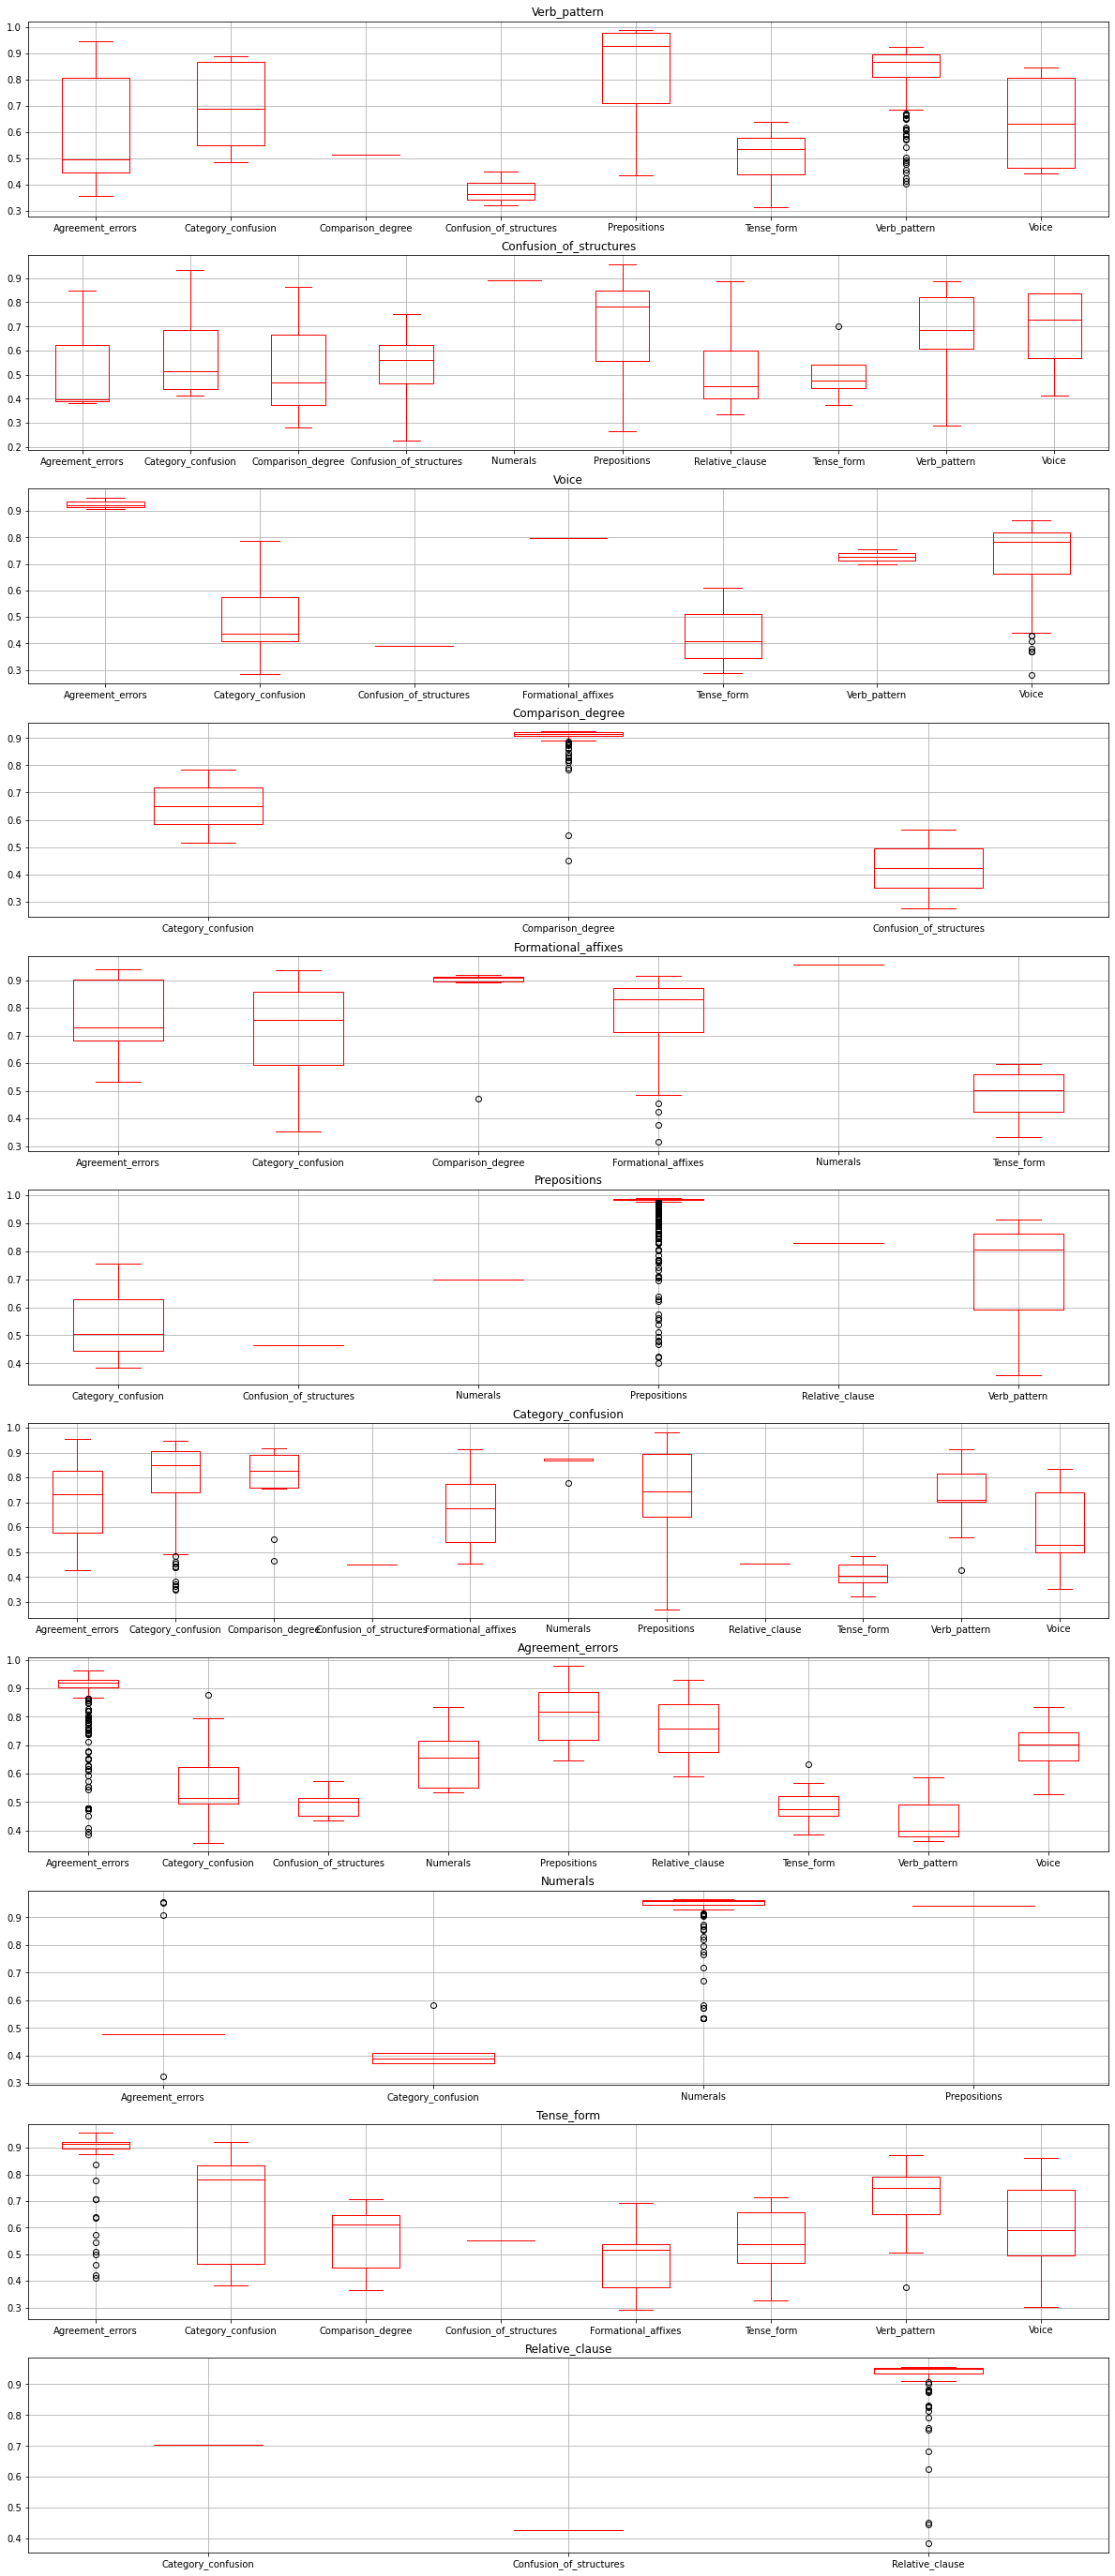

In [21]:
tags = ["Verb_pattern", "Confusion_of_structures",
        "Voice", "Comparison_degree", "Formational_affixes",
        "Prepositions", "Category_confusion",
        "Agreement_errors","Numerals",
        "Tense_form", "Relative_clause"]
fig, ax = plt.subplots(len(tags), figsize=(20,50))
for n, tag in enumerate(tags):
    sub = df.groupby(['target'])
    labels = sorted(set(sub.get_group(tag)['pred'].tolist()))
#     print(labels)
    bp = df[df['target'] == tag].boxplot(column='score', by=['target', 'pred'], 
                                         ax=ax[n], color='r')
    ax[n].set_title(tag)
    ax[n].set_xticks(range(1, len(labels)+1), labels=labels)
    ax[n].set_xlabel('')
    
fig.suptitle('')
plt.show()

## LEXICAL

In [38]:
path_to_model = ...
tokenizer = RobertaTokenizerFast.from_pretrained(path_to_model)
train = pickle.load(open('split_train_lexical_eo.pickle', 'rb'))
data = pd.DataFrame(train, columns=['text', 'tag'])
label2id = {'lex_item_choice': 0, 'lex_part_choice': 1}
id2label = {0: 'lex_item_choice', 1: 'lex_part_choice'}

In [67]:
prediction = TextClassificationPipeline(
    model=RobertaForSequenceClassification.from_pretrained(path_to_model, num_labels=len(id2label), id2label=id2label, label2id=label2id),
    tokenizer=tokenizer,
)

In [79]:
data

,text,label,tag
0,by → with,0,lex_item_choice
1,all of us → we all,0,lex_item_choice
2,made → accept,0,lex_item_choice
3,argument → reason,0,lex_item_choice
4,attendance → admissions,0,lex_item_choice
...,...,...,...
14372,Latina America → Latin America,1,lex_part_choice
14373,every → each,0,lex_item_choice
14374,participants → creators,0,lex_item_choice
14375,want → like,0,lex_item_choice


In [46]:
prediction('made → accept'), prediction('Latina America → Latin America')

([[{'label': 'lex_item_choice', 'score': 0.9973666071891785},
   {'label': 'lex_part_choice', 'score': 0.0026334505528211594}]],
 [[{'label': 'lex_part_choice', 'score': 0.9907699227333069},
   {'label': 'lex_item_choice', 'score': 0.00923010054975748}]])

In [80]:
data = pd.DataFrame(train, columns=['text', 'label'])
data['tag'] = data.apply(lambda x: id2label[x['label']], axis=1)
dataset = Dataset.from_pandas(data[['text', 'label', 'tag']]).class_encode_column('label')
dataset = dataset.train_test_split(test_size=0.2, seed=42)
len(dataset['train']), len(dataset['test'])
df = dataset['test'].to_pandas()
# df

Stringifying the column:   0%|          | 0/14377 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/14377 [00:00<?, ? examples/s]

(11501, 2876)

In [32]:
errors = dict()

for i in id2label.keys():
    print(id2label[i], end=' ')
    sents = df.loc[df['tag'] == id2label[i]]['text'].tolist()
    print(len(sents))
    errors[id2label[i]] = sents

lex_item_choice 2421
lex_part_choice 455


In [33]:
examples = []
corr, wrong, uncertain = 0, 0, 0

for error, sents in tqdm(errors.items()):
    class_wrong, class_corr, class_uncertain = 0, 0, 0
    for sent in tqdm(sents):
        pr = prediction(sent)[0]
        examples.append((sent, error, pr['label'], pr['score']))
        if pr['score'] > 0.85:
            if pr['label'] == error:
                class_corr += 1
            else:
                class_wrong += 1
        else:
            class_uncertain += 1
            
            
    corr += class_corr
    uncertain += class_uncertain
    wrong += class_wrong
        
    print(f'identified correctly in {error}: {class_corr}/{class_corr+class_wrong}, {class_corr/(max(class_corr+class_wrong, 1))*100}%, uncertain {class_uncertain}, total {class_corr+class_wrong+class_uncertain}')
    
print(f'in total: {corr} / {corr/(corr+wrong+uncertain)} correct, {wrong} / {wrong/(corr+wrong+uncertain)} wrong, {uncertain} / {uncertain/(corr+wrong+uncertain)} uncertain')

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2421 [00:00<?, ?it/s]

identified correctly in lex_item_choice: 2304/2368, 97.2972972972973%, uncertain 53, total 2421


  0%|          | 0/455 [00:00<?, ?it/s]

identified correctly in lex_part_choice: 356/429, 82.98368298368298%, uncertain 26, total 455
in total: 2660 / 0.9248956884561892 correct, 137 / 0.0476356050069541 wrong, 79 / 0.027468706536856746 uncertain


In [34]:
df = pd.DataFrame(examples, columns=['error', 'target', 'pred', 'score'])
df.head()

,error,target,pred,score
0,improved → increased,lex_item_choice,lex_item_choice,0.998353
1,cities → countries,lex_item_choice,lex_item_choice,0.997929
2,have → saw,lex_item_choice,lex_item_choice,0.997585
3,was → existed,lex_item_choice,lex_item_choice,0.998119
4,weather → wealth,lex_item_choice,lex_item_choice,0.997860


In [35]:
df.groupby(['target', 'pred']).agg({'error':'count', 'score':['mean', 'median', 'var']})

error     score                    
                                count      mean    median       var
target          pred                                               
lex_item_choice lex_item_choice  2335  0.990947  0.997536  0.001169
                lex_part_choice    86  0.892374  0.960365  0.017904
lex_part_choice lex_item_choice    82  0.948639  0.987063  0.005815
                lex_part_choice   373  0.975044  0.993696  0.003634

In [36]:
df.to_excel('errors_lexical_pred.xlsx')

In [24]:
df = pd.read_excel('errors_lexical_pred.xlsx')

In [11]:
df.groupby(['target', 'pred']).agg({'error':'count', 'score':['mean', 'median', 'var']})

error     score                    
                                count      mean    median       var
target          pred                                               
lex_item_choice lex_item_choice  2335  0.990947  0.997536  0.001169
                lex_part_choice    86  0.892374  0.960365  0.017904
lex_part_choice lex_item_choice    82  0.948639  0.987063  0.005815
                lex_part_choice   373  0.975044  0.993696  0.003634

In [40]:
classes = set(df['target'].tolist())

pr, rec, f1, f05, means = [], [], [], [], []
for cl in classes:
        m1, m2, m3, m4, mean_score = prec_rec_f1(cl)
        pr.append(m1)
        rec.append(m2)
        f1.append(m3)
        f05.append(m4)
        means.append(mean_score)
    
metrics = pd.DataFrame(data = list(zip(classes, pr, rec, f1, f05, means)), columns=['class', 'precision', 'recall', 'F1', 'F0.5', 'mean score'])
metrics

,class,precision,recall,F1,F0.5,mean score
0,lex_part_choice,0.812636,0.819780,0.816193,0.814055,0.970285
1,lex_item_choice,0.966074,0.964477,0.965275,0.965754,0.987446


In [72]:
from collections import Counter
Counter(df['target'].tolist())

Counter({'lex_item_choice': 2421, 'lex_part_choice': 455})

In [51]:
from sklearn.metrics import fbeta_score

for mode in ['weighted', 'micro', 'macro']:
    print(f'{mode} F0.5', 
          fbeta_score(df['target'],
                      df['pred'], 
                      beta=0.5, 
                      average=mode))

weighted F0.5 0.9417543243320324
micro F0.5 0.9415855354659248
macro F0.5 0.8899044945246226


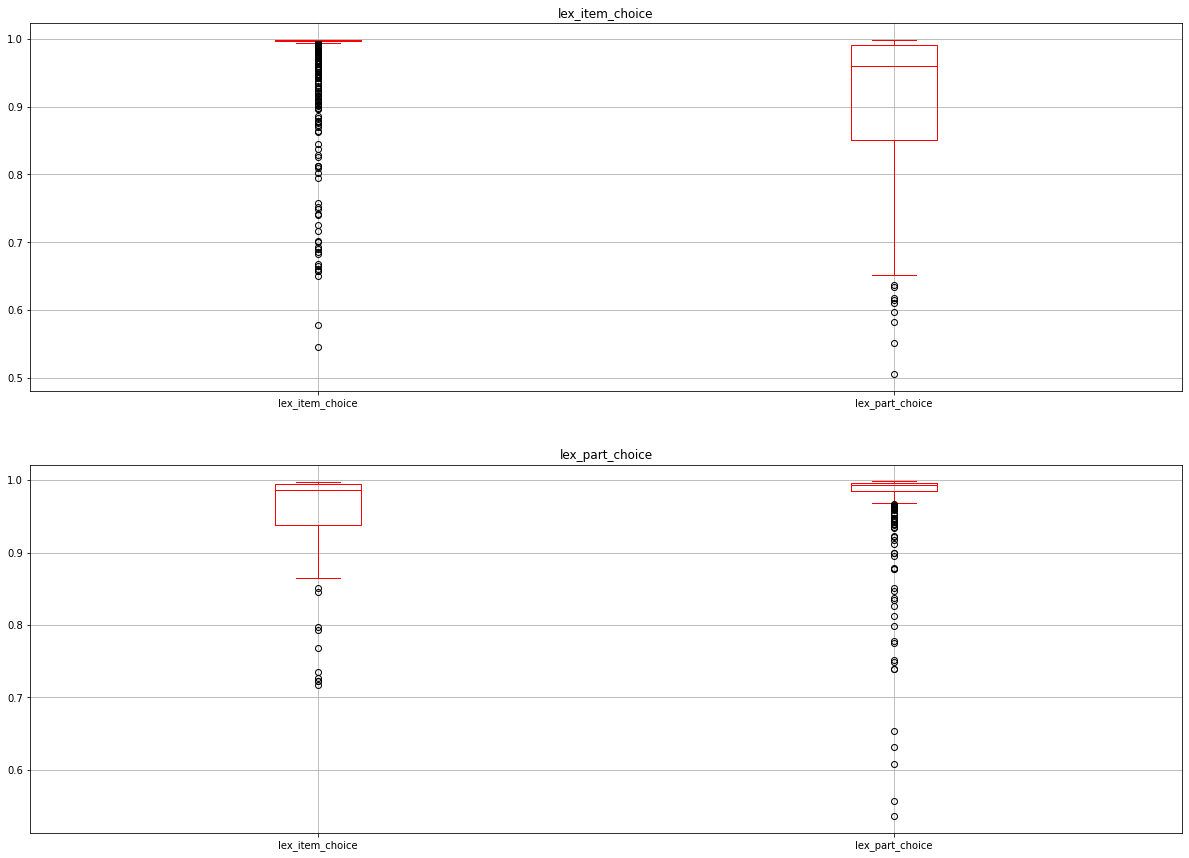

In [27]:
tags = ['lex_item_choice', 'lex_part_choice']
fig, ax = plt.subplots(len(tags), figsize=(20,15))
for n, tag in enumerate(tags):
    sub = df.groupby(['target'])
    labels = sorted(set(sub.get_group(tag)['pred'].tolist()))
#     print(labels)
    bp = df[df['target'] == tag].boxplot(column='score', by=['target', 'pred'], 
                                         ax=ax[n], color='r')
    ax[n].set_title(tag)
    ax[n].set_xticks(range(1, len(labels)+1), labels=labels)
    ax[n].set_xlabel('')
    
fig.suptitle('')
plt.show()